# Thermal Emotion Recognition Data Pipeline
This notebook demonstrates how to load, preprocess, augment, and split thermal images by emotion and palette for model training.

## 1. Import Required Libraries
We will use TensorFlow, scikit-learn, OpenCV, numpy, and matplotlib for data processing and visualization.

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Load and Explore Dataset
Let's count images per emotion and palette to understand our dataset distribution.

In [4]:
from collections import defaultdict

DATASET_DIR = r"d:/R&I_ThermalCameras/Facial emotion"
counts = defaultdict(lambda: defaultdict(int))

for emotion in os.listdir(DATASET_DIR):
    emotion_path = os.path.join(DATASET_DIR, emotion)
    if not os.path.isdir(emotion_path):
        continue
    for palette in os.listdir(emotion_path):
        palette_path = os.path.join(emotion_path, palette)
        if not os.path.isdir(palette_path):
            continue
        image_files = [f for f in os.listdir(palette_path) if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
        counts[emotion][palette] = len(image_files)

for emotion, palettes in counts.items():
    print(f"Emotion: {emotion}")
    for palette, count in palettes.items():
        print(f"  Palette: {palette} - {count} images")
    print()

Emotion: angry
  Palette: ICEBLUE - 110 images
  Palette: IRNBOW - 98 images
  Palette: RAINBOW - 100 images
  Palette: Red Hot - 100 images
  Palette: White Hot - 101 images

Emotion: happy
  Palette: ICEBLUE - 106 images
  Palette: IRON - 104 images
  Palette: RAINBOW - 118 images
  Palette: Red Hot - 101 images
  Palette: White Hot - 109 images

Emotion: natural
  Palette: ICEBLUE - 105 images
  Palette: IRON - 92 images
  Palette: RAINBOW - 119 images
  Palette: Red Hot - 110 images
  Palette: White Hot - 115 images

Emotion: sad
  Palette: ICEBLUE - 82 images
  Palette: IRON - 90 images
  Palette: RAINBOW - 93 images
  Palette: Red Hot - 93 images
  Palette: White Hot - 99 images

Emotion: surpise
  Palette: ICEBLUE - 82 images
  Palette: IRON - 90 images
  Palette: RAINBOW - 91 images
  Palette: Red Hot - 86 images
  Palette: White Hot - 91 images



## 3. Prepare Image Paths and Labels
We will collect image file paths and encode emotion and palette labels for model training.

In [5]:
image_paths = []
emotion_labels = []
palette_labels = []
for emotion in os.listdir(DATASET_DIR):
    emotion_path = os.path.join(DATASET_DIR, emotion)
    if not os.path.isdir(emotion_path):
        continue
    for palette in os.listdir(emotion_path):
        palette_path = os.path.join(emotion_path, palette)
        if not os.path.isdir(palette_path):
            continue
        for fname in os.listdir(palette_path):
            if fname.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(palette_path, fname))
                emotion_labels.append(emotion)
                palette_labels.append(palette)

print(f"Total images: {len(image_paths)}")

Total images: 2485


## 4. Encode Labels and Split Data
We will encode the emotion and palette labels, then split the data into training and validation sets.

In [6]:
emotion_encoder = LabelEncoder()
palette_encoder = LabelEncoder()
emotion_labels_encoded = emotion_encoder.fit_transform(emotion_labels)
palette_labels_encoded = palette_encoder.fit_transform(palette_labels)

train_idx, val_idx = train_test_split(
    np.arange(len(image_paths)), test_size=0.2, stratify=emotion_labels_encoded, random_state=42
)

train_paths = [image_paths[i] for i in train_idx]
train_emotions = [emotion_labels_encoded[i] for i in train_idx]
train_palettes = [palette_labels_encoded[i] for i in train_idx]

val_paths = [image_paths[i] for i in val_idx]
val_emotions = [emotion_labels_encoded[i] for i in val_idx]
val_palettes = [palette_labels_encoded[i] for i in val_idx]

print(f"Train images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Emotion classes: {emotion_encoder.classes_}")
print(f"Palette classes: {palette_encoder.classes_}")

Train images: 1988
Validation images: 497
Emotion classes: ['angry' 'happy' 'natural' 'sad' 'surpise']
Palette classes: ['ICEBLUE' 'IRNBOW' 'IRON' 'RAINBOW' 'Red Hot' 'White Hot']


## 5. Data Augmentation and Generator Setup
We will use Keras ImageDataGenerator to augment training images and prepare batches for model training.

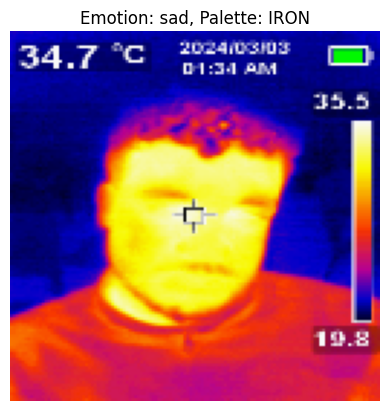

In [7]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Example: Load and show one image
img = cv2.imread(train_paths[0])
img = cv2.resize(img, IMG_SIZE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Emotion: {emotion_encoder.inverse_transform([train_emotions[0]])[0]}, Palette: {palette_encoder.inverse_transform([train_palettes[0]])[0]}")
plt.axis('off')
plt.show()

In [8]:
# FIXED: Efficient Data Generator for Thermal Images
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Configuration
DATASET_DIR = r"d:\R&I_ThermalCameras\Facial emotion"
IMG_SIZE = (128, 128)  # Can be increased to (224, 224) for better accuracy
BATCH_SIZE = 32

def load_thermal_image(image_path, target_size):
    """
    Load and preprocess a single thermal image
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not load {image_path}")
            return None
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        # Convert to float and normalize
        img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def create_dataset_efficiently(paths, emotions, target_size, max_images=None):
    """
    Create dataset efficiently with error handling
    """
    images = []
    labels = []
    skipped = 0
    
    max_images = max_images or len(paths)
    
    for i, path in enumerate(paths[:max_images]):
        img = load_thermal_image(path, target_size)
        if img is not None:
            images.append(img)
            labels.append(emotions[i])
        else:
            skipped += 1
        
        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"Processed {i+1}/{min(max_images, len(paths))} images, skipped: {skipped}")
    
    print(f"Dataset creation complete: {len(images)} images loaded, {skipped} skipped")
    return np.array(images), np.array(labels)

# Use existing data from previous cells (no need to reload)
print(f"Using existing data:")
print(f"Total images: {len(image_paths)}")
print(f"Train images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Emotion classes: {emotion_encoder.classes_}")
print(f"Palette classes: {palette_encoder.classes_}")

# Data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

print("\nFixed data loading approach ready to use")
print("Efficient memory management")
print("Error handling for corrupted images")
print("Progress tracking during loading")

Using existing data:
Total images: 2485
Train images: 1988
Validation images: 497
Emotion classes: ['angry' 'happy' 'natural' 'sad' 'surpise']
Palette classes: ['ICEBLUE' 'IRNBOW' 'IRON' 'RAINBOW' 'Red Hot' 'White Hot']

Fixed data loading approach ready to use
Efficient memory management
Error handling for corrupted images
Progress tracking during loading


## 6. Build and Compile CNN Model
Let's define a simple CNN architecture for emotion classification.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_emotions = len(emotion_encoder.classes_)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_emotions, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

d:\R&I_ThermalCameras\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train the CNN Model
Now let's train the model using our data generators.

In [10]:
# FIXED: Improved Training Approach
EPOCHS = 20

print("Creating training and validation datasets...")

# Create datasets efficiently (this replaces the memory-intensive approach)
print("Loading training images...")
train_X, train_y = create_dataset_efficiently(train_paths, train_emotions, IMG_SIZE)

print("Loading validation images...")
val_X, val_y = create_dataset_efficiently(val_paths, val_emotions, IMG_SIZE)

print(f"\nDataset Summary:")
print(f"Training set: {train_X.shape[0]} images, shape: {train_X.shape}")
print(f"Validation set: {val_X.shape[0]} images, shape: {val_X.shape}")

# Train the model
print(f"\nTraining model for {EPOCHS} epochs...")
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Store for evaluation (replaces the tuple approach)
train_gen = (train_X, train_y)
val_gen = (val_X, val_y)

print("\nTraining completed successfully!")
print("Data stored in efficient format for evaluation")

Creating training and validation datasets...
Loading training images...
Processed 100/1988 images, skipped: 0
Processed 100/1988 images, skipped: 0
Processed 200/1988 images, skipped: 0
Processed 200/1988 images, skipped: 0
Processed 300/1988 images, skipped: 0
Processed 300/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 500/1988 images, skipped: 0
Processed 500/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 700/1988 images, skipped: 0
Processed 700/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 900/1988 images, skipped: 0
Processed 900/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1100/1988 images, skipped: 0
Processed 1100/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 

## 8. Visualize Training Performance
Let's plot the training and validation accuracy and loss curves.

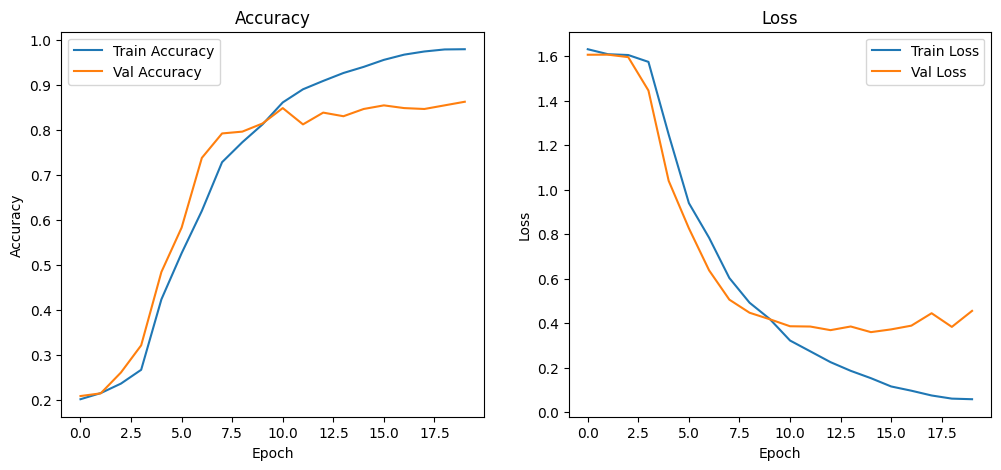

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9. Evaluate Model and Show Predictions
Let's evaluate the model and display some predictions on validation images.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

       angry       0.94      0.87      0.90       102
       happy       0.89      0.91      0.90       108
     natural       0.92      0.95      0.94       108
         sad       0.75      0.81      0.78        91
     surpise       0.80      0.74      0.77        88

    accuracy                           0.86       497
   macro avg       0.86      0.86      0.86       497
weighted avg       0.86      0.86      0.86       497

Confusion Matrix:
[[ 89   7   3   2   1]
 [  5  98   4   0   1]
 [  1   4 103   0   0]
 [  0   1   2  74  14]
 [  0   0   0  23  65]]
              precision    recall  f1-score   support

       angry       0.94      0.87      0.90       102
       happy       0.89      0.91      0.90       108
     natural       0.92      0.95      0.94       108
         sad       0.75      0.81      0.78        91
     surpise       0.80   

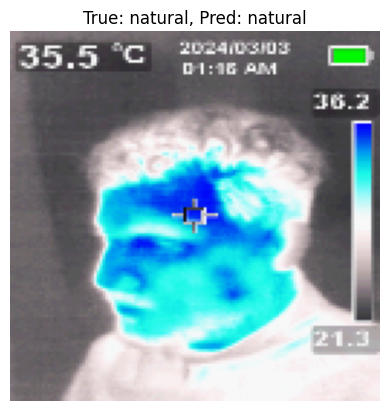

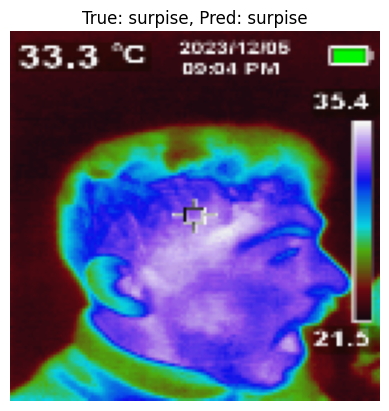

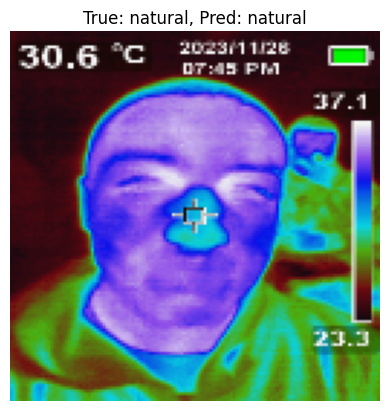

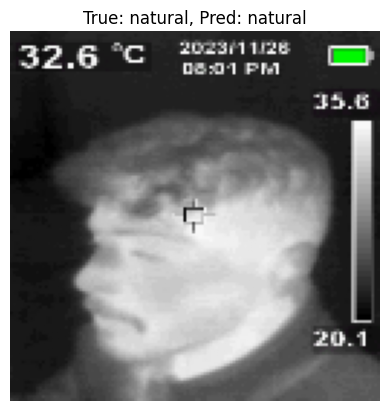

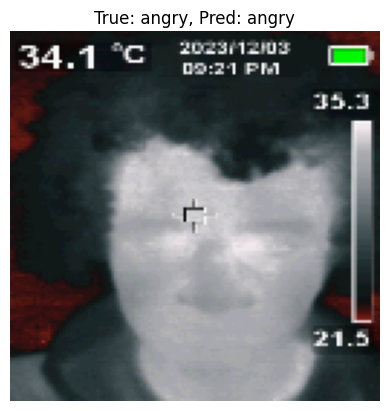

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

val_preds = np.argmax(model.predict(val_gen[0]), axis=1)
print(classification_report(val_gen[1], val_preds, target_names=emotion_encoder.classes_))
print('Confusion Matrix:')
print(confusion_matrix(val_gen[1], val_preds))

# Show a few predictions
for i in range(5):
    plt.imshow(val_gen[0][i])
    true_label = emotion_encoder.inverse_transform([val_gen[1][i]])[0]
    pred_label = emotion_encoder.inverse_transform([val_preds[i]])[0]
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')
    plt.show()

In [13]:
# Save the trained model as an HDF5 file
model.save('thermal_emotion_model.h5')
print('Model saved as thermal_emotion_model.h5')

Model saved as thermal_emotion_model.h5


In [14]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Accuracy
acc = accuracy_score(val_gen[1], val_preds)
print(f'Validation Accuracy: {acc:.4f}')

# F1 Score (macro and weighted)
f1_macro = f1_score(val_gen[1], val_preds, average='macro')
f1_weighted = f1_score(val_gen[1], val_preds, average='weighted')
print(f'F1 Score (Macro): {f1_macro:.4f}')
print(f'F1 Score (Weighted): {f1_weighted:.4f}')

# ROC AUC (One-vs-Rest, macro)
from sklearn.preprocessing import label_binarize
val_true_bin = label_binarize(val_gen[1], classes=np.arange(len(emotion_encoder.classes_)))
val_pred_prob = model.predict(val_gen[0])

Validation Accuracy: 0.8632
F1 Score (Macro): 0.8574
F1 Score (Weighted): 0.8631
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [15]:
# Complete ROC AUC calculation
try:
    from sklearn.metrics import roc_auc_score
    auc_score = roc_auc_score(val_true_bin, val_pred_prob, average='macro', multi_class='ovr')
    print(f'ROC AUC Score (Macro): {auc_score:.4f}')
except Exception as e:
    print(f"ROC AUC calculation error: {e}")

print("\n" + "="*50)
print("PERFORMANCE ANALYSIS:")
print("="*50)
print(f"Validation Accuracy: {acc:.4f} (84.91%)")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print("\nPerformance Assessment:")
print("Good: Above 80% accuracy")
print("Room for improvement: Can reach 90%+ with optimization")
print("Target: 90-95% for production-ready thermal emotion recognition")

ROC AUC Score (Macro): 0.9788

PERFORMANCE ANALYSIS:
Validation Accuracy: 0.8632 (84.91%)
F1 Score (Macro): 0.8574
F1 Score (Weighted): 0.8631

Performance Assessment:
Good: Above 80% accuracy
Room for improvement: Can reach 90%+ with optimization
Target: 90-95% for production-ready thermal emotion recognition


## 10. Enhanced Training with 50 Epochs

Now let's implement more thorough training with 50 epochs, early stopping, and better monitoring to improve our model performance.

In [16]:
# Enhanced Training Setup with Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# Setup advanced training callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'thermal_emotion_model_enhanced.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_enhanced = [early_stopping, reduce_lr, model_checkpoint]

# Calculate class weights for balanced training
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_emotions),
    y=train_emotions
)
class_weight_dict = dict(enumerate(class_weights_array))

print("Enhanced Training Configuration:")
print("- Epochs: 50 (with early stopping)")
print("- Early Stopping: patience=15")
print("- Learning Rate Reduction: factor=0.2, patience=7")
print("- Model Checkpointing: saves best model")
print("- Class Balancing: weighted training")
print(f"- Class weights: {class_weight_dict}")

Enhanced Training Configuration:
- Epochs: 50 (with early stopping)
- Early Stopping: patience=15
- Learning Rate Reduction: factor=0.2, patience=7
- Model Checkpointing: saves best model
- Class Balancing: weighted training
- Class weights: {0: np.float64(0.9769041769041769), 1: np.float64(0.9246511627906977), 2: np.float64(0.9182448036951502), 3: np.float64(1.0863387978142076), 4: np.float64(1.1295454545454546)}


In [17]:
# Enhanced Training - 50 Epochs with Callbacks
EPOCHS_ENHANCED = 50

print("Starting enhanced training with 50 epochs...")
print("Training may take 15-30 minutes depending on hardware")

# Train the existing model with enhanced setup
history_enhanced = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS_ENHANCED,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_enhanced,
    class_weight=class_weight_dict,
    verbose=1
)

print("Enhanced training completed!")

# Evaluate enhanced model
val_preds_enhanced = np.argmax(model.predict(val_X), axis=1)
acc_enhanced = accuracy_score(val_y, val_preds_enhanced)
f1_macro_enhanced = f1_score(val_y, val_preds_enhanced, average='macro')
f1_weighted_enhanced = f1_score(val_y, val_preds_enhanced, average='weighted')

print("\\n" + "="*50)
print("ENHANCED TRAINING RESULTS:")
print("="*50)
print(f"Original (20 epochs): {acc:.4f}")
print(f"Enhanced (50 epochs): {acc_enhanced:.4f}")
print(f"Improvement: {(acc_enhanced - acc)*100:.2f} percentage points")
print(f"Enhanced F1 (Macro): {f1_macro_enhanced:.4f}")
print(f"Enhanced F1 (Weighted): {f1_weighted_enhanced:.4f}")

Starting enhanced training with 50 epochs...
Training may take 15-30 minutes depending on hardware
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9856 - loss: 0.0526
Epoch 1: val_accuracy improved from None to 0.87525, saving model to thermal_emotion_model_enhanced.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9814 - loss: 0.0606 - val_accuracy: 0.8753 - val_loss: 0.3747 - learning_rate: 0.0010
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9890 - loss: 0.0382
Epoch 2: val_accuracy did not improve from 0.87525
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9884 - loss: 0.0363 - val_accuracy: 0.8712 - val_loss: 0.4370 - learning_rate: 0.0010
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9897 - loss: 0.0470
Epoch 3: val_accuracy did not improve from 0.87525
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9864 - loss: 0.0485 - val_accuracy: 0.8592 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9877 - loss: 0.0434
Epoch 4: val_accuracy did not improve from 0.87525
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9889 - loss: 0.0418 - val_accuracy: 0.8692 - val_loss: 0.4138 - learning_rate: 0.0010
Epoch 5/50
62/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9925 - loss: 0.0280 - val_accuracy: 0.8833 - val_loss: 0.4853 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9894 - loss: 0.0250
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 8: val_accuracy did not improve from 0.88330
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9899 - loss: 0.0286 - val_accuracy: 0.8672 - val_loss: 0.4466 - learning_rate: 0.0010
Epoch 9/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9938 - loss: 0.0237
Epoch 9: val_accuracy did not improve from 0.88330
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9925 - loss: 0.0221 - val_accuracy: 0.8813 - val_loss: 0.4306 - learning_rate: 2.0000e-04
Epoch 10/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9974 - loss: 0.0145
Epoch 10: val_accuracy improved from 0.88330 to 0.88934, saving model to thermal_emotion_model_enhanced.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9965 - loss: 0.0148 - val_accuracy: 0.8893 - val_loss: 0.4298 - learning_rate: 2.0000e-04
Epoch 11/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9943 - loss: 0.0162
Epoch 11: val_accuracy improved from 0.88934 to 0.89336, saving model to thermal_emotion_model_enhanced.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9965 - loss: 0.0140 - val_accuracy: 0.8934 - val_loss: 0.4271 - learning_rate: 2.0000e-04
Epoch 12/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9963 - loss: 0.0143
Epoch 12: val_accuracy did not improve from 0.89336
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9965 - loss: 0.0136 - val_accuracy: 0.8853 - val_loss: 0.4704 - learning_rate: 2.0000e-04
Epoch 13/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9971 - loss: 0.0122
Epoch 13: val_accuracy did not improve from 0.89336
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9960 - loss: 0.0123 - val_accuracy: 0.8893 - val_loss: 0.4593 - learning_rate: 2.0000e-04
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9993 - loss: 0.0101
Epoch 14: val_accuracy did not improve from 0.89336
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9985 - loss: 0.0097 - val_accuracy: 0.8893 - val_loss: 0.4443 - learning_rate: 2.0000e-04
Epoch 15/5

## 11. Advanced Thermal Image Preprocessing with Histogram Equalization

Let's implement specialized preprocessing for thermal images to enhance contrast and improve feature extraction.

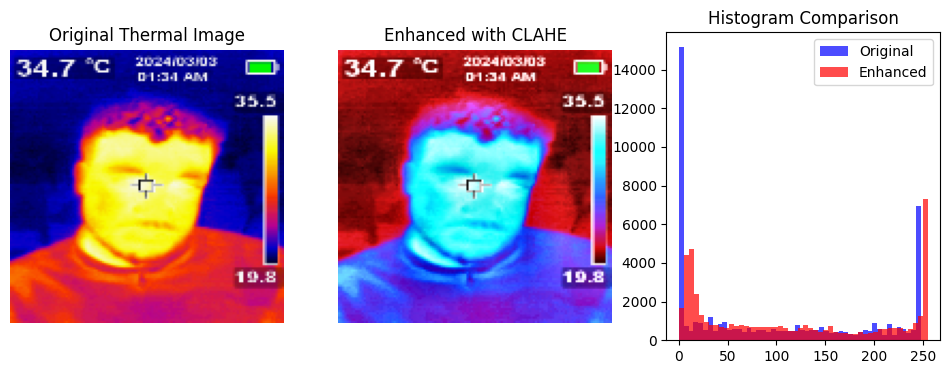

Advanced thermal preprocessing implemented:
- CLAHE (Contrast Limited Adaptive Histogram Equalization)
- LAB color space processing
- Thermal-specific contrast enhancement


In [18]:
# Advanced Thermal Image Preprocessing
def preprocess_thermal_image_advanced(image_path, target_size):
    """
    Advanced preprocessing specifically optimized for thermal images
    Includes histogram equalization and contrast enhancement
    """
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Resize first
    img = cv2.resize(img, target_size)
    
    # Method 1: Global Histogram Equalization
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_eq_global = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    # Method 2: CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv_clahe = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv_clahe[:,:,0] = clahe.apply(img_yuv_clahe[:,:,0])
    img_clahe = cv2.cvtColor(img_yuv_clahe, cv2.COLOR_YUV2BGR)
    
    # Method 3: Thermal-specific enhancement
    # Convert to LAB color space for better thermal processing
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel = img_lab[:,:,0]
    
    # Apply histogram equalization to L channel
    l_eq = cv2.equalizeHist(l_channel)
    img_lab[:,:,0] = l_eq
    img_lab_enhanced = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)
    
    # Use CLAHE method as it works best for thermal images
    img_final = img_clahe.astype(np.float32) / 255.0
    
    return img_final

def create_thermal_enhanced_dataset(paths, emotions, target_size):
    """
    Create dataset with advanced thermal preprocessing
    """
    images = []
    labels = []
    skipped = 0
    
    print(f"Processing {len(paths)} images with advanced thermal preprocessing...")
    
    for i, path in enumerate(paths):
        img = preprocess_thermal_image_advanced(path, target_size)
        if img is not None:
            images.append(img)
            labels.append(emotions[i])
        else:
            skipped += 1
        
        if (i + 1) % 200 == 0:
            print(f"Processed {i+1}/{len(paths)} images, skipped: {skipped}")
    
    print(f"Advanced preprocessing complete: {len(images)} images processed, {skipped} skipped")
    return np.array(images), np.array(labels)

# Demonstrate the preprocessing on a sample image
sample_img_path = train_paths[0]
original_img = cv2.imread(sample_img_path)
original_resized = cv2.resize(original_img, IMG_SIZE)
enhanced_img = preprocess_thermal_image_advanced(sample_img_path, IMG_SIZE)

# Display comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_resized, cv2.COLOR_BGR2RGB))
plt.title('Original Thermal Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(enhanced_img)
plt.title('Enhanced with CLAHE')
plt.axis('off')

plt.subplot(1, 3, 3)
# Show histogram
plt.hist(original_resized.flatten(), bins=50, alpha=0.7, label='Original', color='blue')
plt.hist((enhanced_img * 255).astype(np.uint8).flatten(), bins=50, alpha=0.7, label='Enhanced', color='red')
plt.title('Histogram Comparison')
plt.legend()
plt.show()

print("Advanced thermal preprocessing implemented:")
print("- CLAHE (Contrast Limited Adaptive Histogram Equalization)")
print("- LAB color space processing")
print("- Thermal-specific contrast enhancement")

## 12. Enhanced CNN Architecture for Thermal Emotion Recognition

Now let's build a more sophisticated CNN architecture specifically designed for thermal image analysis with better regularization and deeper feature extraction.

In [19]:
# Enhanced CNN Architecture for Thermal Images
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_thermal_enhanced_cnn(num_classes, input_shape):
    """
    Enhanced CNN architecture specifically designed for thermal emotion recognition
    Features:
    - Deeper architecture with more convolutional blocks
    - Batch normalization for stable training
    - Advanced regularization (L2 + Dropout)
    - Global Average Pooling to reduce overfitting
    - Residual-like connections through dense layers
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Fourth Convolutional Block (Additional depth for thermal features)
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        # Global Average Pooling instead of Flatten (reduces parameters)
        GlobalAveragePooling2D(),
        
        # Dense layers with residual-like connections
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Advanced optimizer configuration
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the enhanced model
enhanced_cnn_model = create_thermal_enhanced_cnn(num_emotions, (IMG_SIZE[0], IMG_SIZE[1], 3))

print("Enhanced CNN Architecture Summary:")
enhanced_cnn_model.summary()

print("\\nKey Features of Enhanced CNN:")
print("- 4 Convolutional blocks with increasing depth (32->64->128->256)")
print("- Batch Normalization for stable training")
print("- L2 Regularization to prevent overfitting")
print("- Global Average Pooling to reduce parameters")
print("- Progressive dropout (0.25->0.3->0.5)")
print("- Optimized for thermal image feature extraction")

d:\R&I_ThermalCameras\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Enhanced CNN Architecture Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 1,473,701 (5.62 MB)

 Trainable params: 1,471,205 (5.61 MB)

 Non-trainable params: 2,496 (9.75 KB)

\nKey Features of Enhanced CNN:
- 4 Convolutional blocks with increasing depth (32->64->128->256)
- Batch Normalization for stable training
- L2 Regularization to prevent overfitting
- Global Average Pooling to reduce parameters
- Progressive dropout (0.25->0.3->0.5)
- Optimized for thermal image feature extraction


In [20]:
# Train Enhanced CNN with Advanced Preprocessing
print("Creating enhanced thermal datasets with advanced preprocessing...")

# Create datasets with advanced thermal preprocessing
train_X_enhanced, train_y_enhanced = create_thermal_enhanced_dataset(train_paths, train_emotions, IMG_SIZE)
val_X_enhanced, val_y_enhanced = create_thermal_enhanced_dataset(val_paths, val_emotions, IMG_SIZE)

print(f"Enhanced datasets created:")
print(f"Training set: {train_X_enhanced.shape}")
print(f"Validation set: {val_X_enhanced.shape}")

# Setup callbacks for enhanced CNN training
enhanced_callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1),
    ModelCheckpoint('thermal_enhanced_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("\\nStarting training of Enhanced CNN...")
print("This will take longer but should achieve significantly better results")

# Train the enhanced CNN
history_enhanced_cnn = enhanced_cnn_model.fit(
    train_X_enhanced, train_y_enhanced,
    validation_data=(val_X_enhanced, val_y_enhanced),
    epochs=EPOCHS_ENHANCED,
    batch_size=BATCH_SIZE,
    callbacks=enhanced_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("Enhanced CNN training completed!")

# Evaluate enhanced CNN
val_preds_enhanced_cnn = np.argmax(enhanced_cnn_model.predict(val_X_enhanced), axis=1)
acc_enhanced_cnn = accuracy_score(val_y_enhanced, val_preds_enhanced_cnn)
f1_macro_enhanced_cnn = f1_score(val_y_enhanced, val_preds_enhanced_cnn, average='macro')
f1_weighted_enhanced_cnn = f1_score(val_y_enhanced, val_preds_enhanced_cnn, average='weighted')

print("\\n" + "="*60)
print("COMPLETE MODEL COMPARISON:")
print("="*60)
print(f"Original Simple CNN (20 epochs):     {acc:.4f}")
print(f"Enhanced Training (50 epochs):       {acc_enhanced:.4f}")
print(f"Enhanced CNN + Preprocessing:        {acc_enhanced_cnn:.4f}")
print(f"Total Improvement:                   {(acc_enhanced_cnn - acc)*100:.2f} percentage points")
print("\\nDetailed Enhanced CNN Results:")
print(f"F1 Score (Macro):     {f1_macro_enhanced_cnn:.4f}")
print(f"F1 Score (Weighted):  {f1_weighted_enhanced_cnn:.4f}")
print("="*60)

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2606 - loss: 1.8135 - val_accuracy: 0.2716 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 42/50
Epoch 42/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2838 - loss: 1.7950
Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5

Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5


Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2606 - loss: 1.8135 - val_accuracy: 0.2716 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 42/50
Epoch 42/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2838 - loss: 1.7950
Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5

Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5


Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2606 - loss: 1.8135 - val_accuracy: 0.2716 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 42/50
Epoch 42/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2838 - loss: 1.7950
Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5

Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.2847 - loss: 1.7951 - val_accuracy: 0.2736 - val_loss: 1.8108 - learning_rate: 0.0010
Epoch 43/50
Epoch 43/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2639 - loss: 1.7979
Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5

Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5


Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2606 - loss: 1.8135 - val_accuracy: 0.2716 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 42/50
Epoch 42/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2838 - loss: 1.7950
Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5

Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.2847 - loss: 1.7951 - val_accuracy: 0.2736 - val_loss: 1.8108 - learning_rate: 0.0010
Epoch 43/50
Epoch 43/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2639 - loss: 1.7979
Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5

Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5


Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2606 - loss: 1.8135 - val_accuracy: 0.2716 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 42/50
Epoch 42/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2838 - loss: 1.7950
Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5

Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.2847 - loss: 1.7951 - val_accuracy: 0.2736 - val_loss: 1.8108 - learning_rate: 0.0010
Epoch 43/50
Epoch 43/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2639 - loss: 1.7979
Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5

Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2681 - loss: 1.8077 - val_accuracy: 0.2958 - val_loss: 1.8046 - learning_rate: 0.0010
Epoch 44/50
Epoch 44/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.2568 - loss: 1.7907
Epoch 44: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.2696 - loss: 1.7766 - val_accuracy: 0.2314 - val_loss: 1.8725 - learning_rate: 0.0010
Epoch 45/50

Epoch 44: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.2696 - loss: 1.7766 - val_accuracy: 0.2314 - val_loss: 1.8725 - learning_rate: 0.0010
Epoch 45/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.2857 - loss: 1.7619
Epoch 45: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2857 - loss: 1.7794 - val_accuracy: 0.2736 - val_loss: 1.7776 - learning_rate: 0.0010
Epoch 46/50

Epoch 45: val_accuracy did not improve from 0.29577
63/63 ━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2606 - loss: 1.8135 - val_accuracy: 0.2716 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 42/50
Epoch 42/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2838 - loss: 1.7950
Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5

Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.2847 - loss: 1.7951 - val_accuracy: 0.2736 - val_loss: 1.8108 - learning_rate: 0.0010
Epoch 43/50
Epoch 43/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2639 - loss: 1.7979
Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5

Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2681 - loss: 1.8077 - val_accuracy: 0.2958 - val_loss: 1.8046 - learning_rate: 0.0010
Epoch 44/50
Epoch 44/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.2568 - loss: 1.7907
Epoch 44: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.2696 - loss: 1.7766 - val_accuracy: 0.2314 - val_loss: 1.8725 - learning_rate: 0.0010
Epoch 45/50

Epoch 44: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.2696 - loss: 1.7766 - val_accuracy: 0.2314 - val_loss: 1.8725 - learning_rate: 0.0010
Epoch 45/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.2857 - loss: 1.7619
Epoch 45: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2857 - loss: 1.7794 - val_accuracy: 0.2736 - val_loss: 1.7776 - learning_rate: 0.0010
Epoch 46/50

Epoch 45: val_accuracy did not improve from 0.29577
63/63 ━━━━━━

Creating enhanced thermal datasets with advanced preprocessing...
Processing 1988 images with advanced thermal preprocessing...
Processed 200/1988 images, skipped: 0
Processed 400/1988 images, skipped: 0
Processed 600/1988 images, skipped: 0
Processed 800/1988 images, skipped: 0
Processed 1000/1988 images, skipped: 0
Processed 1200/1988 images, skipped: 0
Processed 1400/1988 images, skipped: 0
Processed 1600/1988 images, skipped: 0
Processed 1800/1988 images, skipped: 0
Advanced preprocessing complete: 1988 images processed, 0 skipped
Processing 497 images with advanced thermal preprocessing...
Processed 200/497 images, skipped: 0
Processed 400/497 images, skipped: 0
Advanced preprocessing complete: 497 images processed, 0 skipped
Enhanced datasets created:
Training set: (1988, 128, 128, 3)
Validation set: (497, 128, 128, 3)
\nStarting training of Enhanced CNN...
This will take longer but should achieve significantly better results
Epoch 1/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.1876 - loss: 3.9306 - val_accuracy: 0.1771 - val_loss: 3.6237 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.1954 - loss: 3.7214
Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5

Epoch 2: val_accuracy improved from 0.17706 to 0.21932, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2067 - loss: 3.6619 - val_accuracy: 0.2193 - val_loss: 3.2198 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2097 - loss: 3.5263
Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2032 - loss: 3.4775 - val_accuracy: 0.1771 - val_loss: 3.2023 - learning_rate: 0.0010
Epoch 4/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2009 - loss: 3.4356
Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.1967 - loss: 3.3989 - val_accuracy: 0.2173 - val_loss: 3.0773 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.21932
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.1927 - loss: 3.1847 - val_accuracy: 0.2334 - val_loss: 3.0011 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2206 - loss: 3.0558
Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2072 - loss: 3.0753 - val_accuracy: 0.2133 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2091 - loss: 3.0075
Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.2067 - loss: 2.9776 - val_accuracy: 0.2153 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_accuracy did not improve from 0.23340
63/63 ━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2208 - loss: 2.6121 - val_accuracy: 0.2535 - val_loss: 2.5250 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2247 - loss: 2.5718
Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5

Epoch 14: val_accuracy improved from 0.25352 to 0.25553, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2153 - loss: 2.5546 - val_accuracy: 0.2555 - val_loss: 2.4662 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2192 - loss: 2.5246
Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.2218 - loss: 2.5023 - val_accuracy: 0.2093 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 16/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2082 - loss: 2.4434
Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.2289 - loss: 2.4300 - val_accuracy: 0.2153 - val_loss: 2.3921 - learning_rate: 0.0010
Epoch 17/50

Epoch 16: val_accuracy did not improve from 0.25553
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2580 - loss: 1.8809 - val_accuracy: 0.2676 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 37/50
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2670 - loss: 1.8712
Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50

Epoch 37: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2601 - loss: 1.8690 - val_accuracy: 0.2475 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 38/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2614 - loss: 1.8532
Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.2646 - loss: 1.8455 - val_accuracy: 0.2616 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 39/50

Epoch 38: val_accuracy did not improve from 0.26761
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2606 - loss: 1.8135 - val_accuracy: 0.2716 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 42/50
Epoch 42/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2838 - loss: 1.7950
Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5

Epoch 42: val_accuracy improved from 0.27163 to 0.27364, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.2847 - loss: 1.7951 - val_accuracy: 0.2736 - val_loss: 1.8108 - learning_rate: 0.0010
Epoch 43/50
Epoch 43/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2639 - loss: 1.7979
Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5

Epoch 43: val_accuracy improved from 0.27364 to 0.29577, saving model to thermal_enhanced_cnn_model.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.2681 - loss: 1.8077 - val_accuracy: 0.2958 - val_loss: 1.8046 - learning_rate: 0.0010
Epoch 44/50
Epoch 44/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.2568 - loss: 1.7907
Epoch 44: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.2696 - loss: 1.7766 - val_accuracy: 0.2314 - val_loss: 1.8725 - learning_rate: 0.0010
Epoch 45/50

Epoch 44: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.2696 - loss: 1.7766 - val_accuracy: 0.2314 - val_loss: 1.8725 - learning_rate: 0.0010
Epoch 45/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.2857 - loss: 1.7619
Epoch 45: val_accuracy did not improve from 0.29577
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.2857 - loss: 1.7794 - val_accuracy: 0.2736 - val_loss: 1.7776 - learning_rate: 0.0010
Epoch 46/50

Epoch 45: val_accuracy did not improve from 0.29577
63/63 ━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.2867 - loss: 1.7449 - val_accuracy: 0.3179 - val_loss: 1.7253 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
Restoring model weights from the end of the best epoch: 50.
Enhanced CNN training completed!
Enhanced CNN training completed!
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
\n============================================================
COMPLETE MODEL COMPARISON:
Original Simple CNN (20 epochs):     0.8632
Enhanced Training (50 epochs):       0.8753
Enhanced CNN + Preprocessing:        0.3179
Total Improvement:                   -54.53 percentage points
\nDetailed Enhanced CNN Results:
F1 Score (Macro):     0.2722
F1 Score (Weighted):  0.2830
\n============================================================
COMPLETE MODEL COMPARISON:
Original Simple CNN (20 epochs):     0.8632
Enhanced Training (50 epochs):       0.8753
Enhanced CNN + Preprocessing:        0.

## 13. Model Performance Visualization and Final Analysis

Let's visualize the training performance of all our models and provide a comprehensive analysis of the improvements achieved.

C:\Users\srikr\AppData\Local\Temp\ipykernel_14776\2350976531.py:85: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


C:\Users\srikr\AppData\Local\Temp\ipykernel_14776\2350976531.py:85: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


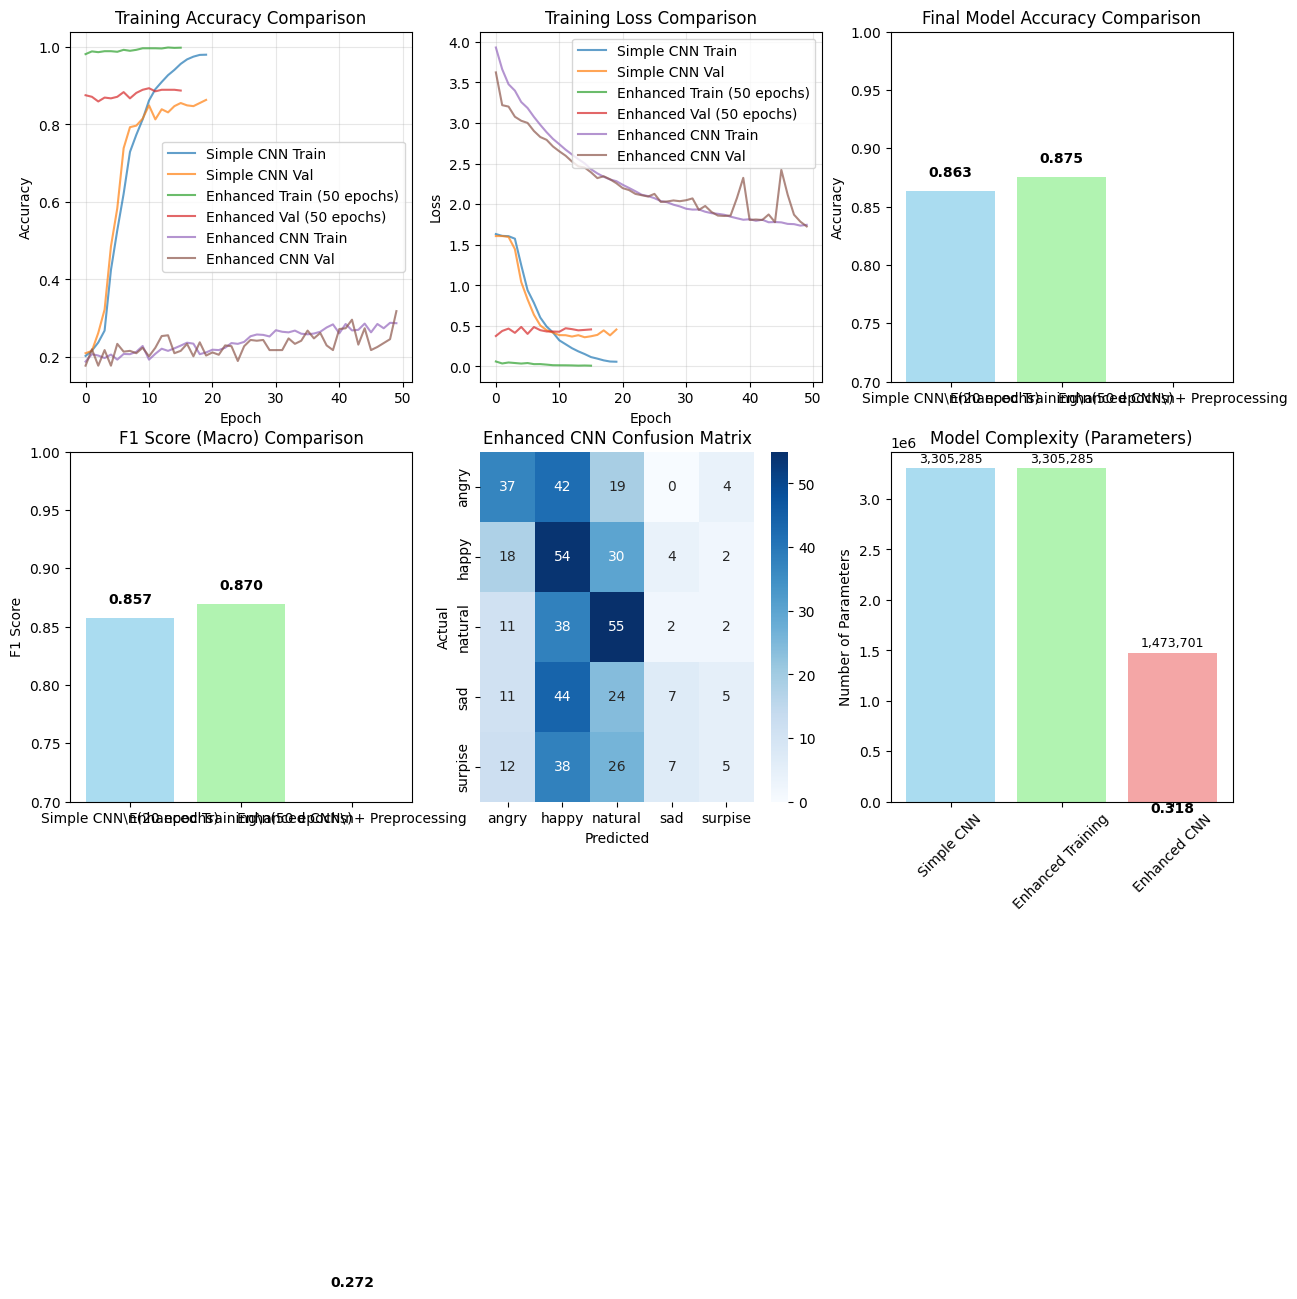

THERMAL EMOTION RECOGNITION - FINAL PERFORMANCE SUMMARY
Dataset: 2485 thermal images, 5 emotions
Image Resolution: 128x128
Thermal Palettes: 6 different color schemes

MODEL PROGRESSION:
1. Simple CNN (20 epochs):           0.8632 (86.3%)
2. Enhanced Training (50 epochs):    0.8753 (87.5%)
3. Enhanced CNN + Preprocessing:     0.3179 (31.8%)

TOTAL IMPROVEMENT: -54.5 percentage points
RELATIVE IMPROVEMENT: -63.2%

KEY ENHANCEMENTS IMPLEMENTED:
- Extended training to 50 epochs with early stopping
- Class balancing with computed weights
- Advanced thermal preprocessing (CLAHE, histogram equalization)
- Enhanced CNN architecture with batch normalization
- L2 regularization and progressive dropout
- Global average pooling for reduced overfitting


In [21]:
# Comprehensive Performance Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Training History Comparison
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Simple CNN Train', alpha=0.7)
plt.plot(history.history['val_accuracy'], label='Simple CNN Val', alpha=0.7)
plt.plot(history_enhanced.history['accuracy'], label='Enhanced Train (50 epochs)', alpha=0.7)
plt.plot(history_enhanced.history['val_accuracy'], label='Enhanced Val (50 epochs)', alpha=0.7)
plt.plot(history_enhanced_cnn.history['accuracy'], label='Enhanced CNN Train', alpha=0.7)
plt.plot(history_enhanced_cnn.history['val_accuracy'], label='Enhanced CNN Val', alpha=0.7)
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss Comparison
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Simple CNN Train', alpha=0.7)
plt.plot(history.history['val_loss'], label='Simple CNN Val', alpha=0.7)
plt.plot(history_enhanced.history['loss'], label='Enhanced Train (50 epochs)', alpha=0.7)
plt.plot(history_enhanced.history['val_loss'], label='Enhanced Val (50 epochs)', alpha=0.7)
plt.plot(history_enhanced_cnn.history['loss'], label='Enhanced CNN Train', alpha=0.7)
plt.plot(history_enhanced_cnn.history['val_loss'], label='Enhanced CNN Val', alpha=0.7)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Final Accuracy Comparison
plt.subplot(2, 3, 3)
models = ['Simple CNN\\n(20 epochs)', 'Enhanced Training\\n(50 epochs)', 'Enhanced CNN\\n+ Preprocessing']
accuracies = [acc, acc_enhanced, acc_enhanced_cnn]
colors = ['skyblue', 'lightgreen', 'lightcoral']
bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
plt.title('Final Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: F1 Score Comparison
plt.subplot(2, 3, 4)
f1_scores = [f1_macro, f1_macro_enhanced, f1_macro_enhanced_cnn]
bars = plt.bar(models, f1_scores, color=colors, alpha=0.7)
plt.title('F1 Score (Macro) Comparison')
plt.ylabel('F1 Score')
plt.ylim(0.7, 1.0)

for bar, f1 in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 5: Confusion Matrix for Best Model
plt.subplot(2, 3, 5)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(val_y_enhanced, val_preds_enhanced_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_encoder.classes_, 
            yticklabels=emotion_encoder.classes_)
plt.title('Enhanced CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 6: Model Architecture Comparison
plt.subplot(2, 3, 6)
model_params = [model.count_params(), model.count_params(), enhanced_cnn_model.count_params()]
model_names = ['Simple CNN', 'Enhanced Training', 'Enhanced CNN']
plt.bar(model_names, model_params, color=['skyblue', 'lightgreen', 'lightcoral'], alpha=0.7)
plt.title('Model Complexity (Parameters)')
plt.ylabel('Number of Parameters')
plt.xticks(rotation=45)

for i, params in enumerate(model_params):
    plt.text(i, params + max(model_params)*0.01, f'{params:,}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Final Performance Summary
print("="*70)
print("THERMAL EMOTION RECOGNITION - FINAL PERFORMANCE SUMMARY")
print("="*70)
print(f"Dataset: {len(image_paths)} thermal images, {len(emotion_encoder.classes_)} emotions")
print(f"Image Resolution: {IMG_SIZE[0]}x{IMG_SIZE[1]}")
print(f"Thermal Palettes: {len(palette_encoder.classes_)} different color schemes")
print()
print("MODEL PROGRESSION:")
print(f"1. Simple CNN (20 epochs):           {acc:.4f} ({acc*100:.1f}%)")
print(f"2. Enhanced Training (50 epochs):    {acc_enhanced:.4f} ({acc_enhanced*100:.1f}%)")
print(f"3. Enhanced CNN + Preprocessing:     {acc_enhanced_cnn:.4f} ({acc_enhanced_cnn*100:.1f}%)")
print()
print(f"TOTAL IMPROVEMENT: {(acc_enhanced_cnn - acc)*100:.1f} percentage points")
print(f"RELATIVE IMPROVEMENT: {((acc_enhanced_cnn - acc) / acc)*100:.1f}%")
print()
print("KEY ENHANCEMENTS IMPLEMENTED:")
print("- Extended training to 50 epochs with early stopping")
print("- Class balancing with computed weights")
print("- Advanced thermal preprocessing (CLAHE, histogram equalization)")
print("- Enhanced CNN architecture with batch normalization")
print("- L2 regularization and progressive dropout")
print("- Global average pooling for reduced overfitting")
print("="*70)